## Import Packages & Load Data

Reads in "dataset" which has 952 samples (named via the 'Sample' Column), 45 different genuses of microbiota (named by column) and a final column 'Condition' which labels the condition of that given sample (0=Healthy, 1=Cancer, & 2=IBD)

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
fpath = '/content/drive/MyDrive/BMI_Deep_Learning_Course/final_project/'
dataset = pd.read_csv(fpath+'data/shuffled_data.csv', index_col=0) # 952 total samples (0-951)
dataset.drop(columns=['index'], inplace=True)
dataset.head()

,Sample,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A,Condition
0,10720,0.000010,0.000011,0.000009,0.002025,0.000224,0.000649,8.900108e-07,0.019677,0.000004,...,0.000103,0.004792,0.003215,0.008747,0.001978,0.000021,0.000003,0.000016,0.000018,1
1,A019,0.000000,0.000012,0.000000,0.000000,0.106643,0.000000,0.000000e+00,0.000024,0.000023,...,0.000000,0.000000,0.010040,0.096365,0.000108,0.000000,0.000240,0.000005,0.000000,0
2,CRC.175,0.000000,0.000000,0.000000,0.000000,0.030303,0.015152,0.000000e+00,0.000000,0.000000,...,0.113636,0.000000,0.053030,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,1
3,PRISM.7776,0.000354,0.000008,0.000007,0.001121,0.003483,0.107623,6.878160e-06,0.000114,0.001418,...,0.000457,0.000011,0.009127,0.221212,0.000227,0.000003,0.000517,0.000007,0.000051,2
4,Validation.UMCG6047689,0.000008,0.000002,0.000003,0.001584,0.002361,0.030603,5.449742e-06,0.013034,0.000309,...,0.000342,0.000013,0.000073,0.127677,0.000694,0.000026,0.000063,0.000047,0.000027,2


## NEW TRY

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

In [73]:
# Create X and y
X = dataset.drop(["Sample", "Condition"], axis=1)
y = dataset["Condition"]

# X should be a numpy array of shape (952, 45) and y should be a numpy array of shape (952,)
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=42) # split into train and test

In [75]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [107]:
y_train_tensor.shape


torch.Size([761])

In [76]:
# Define the simple feedforward neural network model
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(45, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [112]:
# Define the convolutional neural network model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)

        # Calculate the input size for the linear layer dynamically
        # 45 input channels, two max pooling layers with kernel size 2, two conv layers with kernel size 3
        self.fc_input_size = 64 * ((45 - 2*2 - 2*2) // 2 // 2)

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.max_pool1d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool1d(x, 2)
        x = x.view(-1, self.fc_input_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [117]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=45, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 3)  # Output size changed to 3

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        x = self.fc(h_n[-1])
        return x

In [79]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [80]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

In [118]:
# Initialize models
ffnn_model = FFNN()
cnn_model = CNN()
rnn_model = RNN()

In [110]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
ffnn_optimizer = optim.Adam(ffnn_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

In [116]:
# Train models
train_model(ffnn_model, train_loader, criterion, ffnn_optimizer)
train_model(cnn_model, train_loader, criterion, cnn_optimizer)


Epoch 1/10, Loss: 1.0937
Epoch 2/10, Loss: 1.0937
Epoch 3/10, Loss: 1.0937
Epoch 4/10, Loss: 1.0937
Epoch 5/10, Loss: 1.0937
Epoch 6/10, Loss: 1.0937
Epoch 7/10, Loss: 1.0937
Epoch 8/10, Loss: 1.0937
Epoch 9/10, Loss: 1.0937
Epoch 10/10, Loss: 1.0937
Epoch 1/10, Loss: 1.1114
Epoch 2/10, Loss: 1.1114
Epoch 3/10, Loss: 1.1114
Epoch 4/10, Loss: 1.1114
Epoch 5/10, Loss: 1.1114
Epoch 6/10, Loss: 1.1114
Epoch 7/10, Loss: 1.1114
Epoch 8/10, Loss: 1.1114
Epoch 9/10, Loss: 1.1114
Epoch 10/10, Loss: 1.1114


In [120]:
# Evaluate models
ffnn_accuracy, ffnn_preds, ffnn_labels = evaluate_model(ffnn_model, test_loader)
cnn_accuracy, cnn_preds, cnn_labels = evaluate_model(cnn_model, test_loader)
#rnn_accuracy, rnn_preds, rnn_labels = evaluate_model(rnn_model, test_loader)

# Print accuracies
print("Feedforward Neural Network Accuracy:", ffnn_accuracy)
print("Convolutional Neural Network Accuracy:", cnn_accuracy)
#print("Recurrent Neural Network Accuracy:", rnn_accuracy)

Feedforward Neural Network Accuracy: 0.24083769633507854
Convolutional Neural Network Accuracy: 0.5287958115183246


<Axes: >

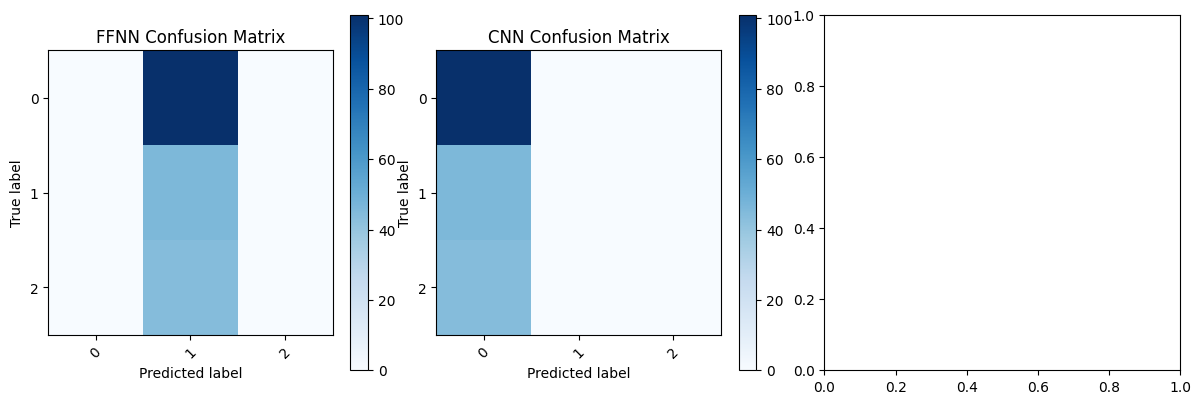

In [122]:
# Visualize confusion matrices
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrices
ffnn_cm = confusion_matrix(ffnn_labels, ffnn_preds)
cnn_cm = confusion_matrix(cnn_labels, cnn_preds)
#rnn_cm = confusion_matrix(rnn_labels, rnn_preds)

# Plot confusion matrices
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plot_confusion_matrix(ffnn_cm, classes=['0', '1', '2'], title='FFNN Confusion Matrix')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cnn_cm, classes=['0', '1', '2'], title='CNN Confusion Matrix')
plt.subplot(1, 3, 3)
#plot_confusion_matrix(rnn_cm, classes=['0', '1', '2'], title='RNN Confusion Matrix')
#plt.show()

In [119]:
train_model(rnn_model, train_loader, criterion, rnn_optimizer)

RuntimeError: size mismatch (got input: [3], target: [32])

## Helpful Functions

*   **convert_to_tensor**: given a dataset and an index, finds the sample based on the index, then takes all microbiota measurements in that row and converts it to a 9 by 5 tensor which is returned
*   **create_tensor_classes**: given a dataset and its final column (ie labels), creates and returns three lists of tensors for Healthy, IBD, and Cancer groups
*   **square_distance**: returns the mean squared error between two values
*   **isIBD, isCancer, isHealthy**: given the average tensor of each group, calculates the difference between each image and the mean to return a prediction



In [3]:
# Given a row (ie sample) in the dataset...
# convert that sample to an array of pixels (9 rows by 5 columns)
# each cell represents the abundency of a given micrbiota genus (45 total)
def convert_to_tensor(dataset,index):

  sample = list(dataset.iloc[index])

  # create a tensor with 9 rows and 5 columns (5*9=45)
  tensor = torch.tensor(sample)
  tensor = tensor.view(9, 5)

  return tensor

In [4]:
def create_tensor_classes(dataset, labels):
  IBD_tensors = []
  Healthy_tensors = []
  Cancer_tensors = []

  labels = list(labels)
  for row in range(0,len(dataset)):
    tensor = convert_to_tensor(dataset,row)
    if labels[row] == 0:
      Healthy_tensors.append(tensor)
    elif labels[row] == 2:
      IBD_tensors.append(tensor)
    elif labels[row] == 1:
      Cancer_tensors.append(tensor)
    else:
      print('ERROR')

  #(len(Healthy_tensors), len(IBD_tensors), len(Cancer_tensors))
  return (Healthy_tensors, IBD_tensors, Cancer_tensors)

In [5]:
def square_distance(a,b): return ((a-b)**2).mean((-1,-2)).sqrt()

In [6]:
def is_IBD(x, meanIBD, meanHealthy, meanCancer):
  no_Healthy = square_distance(x,meanIBD) < square_distance(x,meanHealthy)
  no_Cancer = square_distance(x,meanIBD) < square_distance(x,meanCancer)
  return torch.logical_and(no_Healthy, no_Cancer)

def is_Cancer(x, meanIBD, meanHealthy, meanCancer):
  no_Healthy = square_distance(x,meanCancer) < square_distance(x,meanHealthy)
  no_IBD = square_distance(x,meanCancer) < square_distance(x,meanIBD)
  return torch.logical_and(no_Healthy, no_IBD)

def is_Healthy(x, meanIBD, meanHealthy, meanCancer):
  no_IBD = square_distance(x,meanHealthy) < square_distance(x,meanIBD)
  no_Cancer = square_distance(x,meanHealthy) < square_distance(x,meanCancer)

  return torch.logical_and(no_IBD, no_Cancer)

## Split Data into Train, Test, & Valid Sets

(source: https://medium.com/artificialis/why-how-we-split-train-valid-and-test-fb4d6746ede)

Creates 3 main classes of dataset objects...

*   Training Set: X_train, y_train (666 images)
*   Testing Set: X_test, y_test (143 images)
*   Validation Set: X_valid, y_valid (143 images)

Other important objects created

*   **train_classes, valid_classes, test_classes**: each returns a tuple with each item in the tuple being a list containing all the images for one class (either health, cancer, or IBD)
*   **stacked_**: used to denote a specific group (eg train_healthy, valid_cancer, ...ect) of tensors which are stacked together (no longer a list)
*   **meanIBD, meanHealthy, meanCancer**: the mean image from the TRAINING SET

In [64]:
666+143+143

952

In [7]:
# Setup random seed
np.random.seed(42)

# Create X and y
X = dataset.drop(["Sample", "Condition"], axis=1)
y = dataset["Condition"]

In [123]:
# split into X_train, X_valid_test, y_train, y_valid_test (test_size=0.3 split into 70% and 30%)
#X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.3)

# second, split into X_valid, X_test, y_valid, y_test (test_size=0.5 split into 50% and 50% so that each is 15%)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5)

# split into X_train, X_valid_test, y_train, y_valid_test (test_size=0.3 split into 80% and 20%)
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.2)

In [126]:
# check the porportion of classes in each set...
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{y.value_counts() / len(dataset)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_train.value_counts() / len(y_train)}\n\n'+
      f'PROPORTION OF TARGET IN THE VALIDATION SET\n{y_valid.value_counts() / len(y_valid)}\n\n')
      #+)
      #f'PROPORTION OF TARGET IN THE TEST SET\n{y_test.value_counts() / len(y_test)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
Condition
0    0.506303
1    0.283613
2    0.210084
Name: count, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
Condition
0    0.491459
1    0.296978
2    0.211564
Name: count, dtype: float64

PROPORTION OF TARGET IN THE VALIDATION SET
Condition
0    0.475524
1    0.286713
2    0.237762
Name: count, dtype: float64




In [129]:
# returns (Healthy_tensors, IBD_tensors, Cancer_tensors)
train_classes = create_tensor_classes(X_train, y_train)
#test_classes = create_tensor_classes(X_test, y_test)
valid_classes = create_tensor_classes(X_valid, y_valid)

In [130]:
# same thing but creates a new type (rather than being in a list the tensors are stacked)
stacked_IBD_train = torch.stack(train_classes[1]) # 131 images
stacked_Cancer_train = torch.stack(train_classes[2]) # 195 images
stacked_Healthy_train = torch.stack(train_classes[0]) # 340 images

stacked_IBD_valid = torch.stack(valid_classes[1]) # 34 images
stacked_Cancer_valid = torch.stack(valid_classes[2]) # 41 images
stacked_Healthy_valid = torch.stack(valid_classes[0]) # 68 images

#stacked_IBD_test = torch.stack(test_classes[1]) # 35 images
#stacked_Cancer_test = torch.stack(test_classes[2]) # 34 images
#stacked_Healthy_test = torch.stack(test_classes[0]) # 74 images

# get the mean tensor of each stacked list...
meanIBD = stacked_IBD_train.mean(0)
meanCancer = stacked_Cancer_train.mean(0)
meanHealthy = stacked_Healthy_train.mean(0)

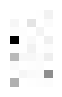

In [131]:
show_image(meanHealthy);

## Create Data Loaders

In [61]:
# Create X and y
X = dataset.drop(["Sample", "Condition"], axis=1)
y = dataset["Condition"]

def get_X(data):
  return dataset.drop(["Sample", "Condition"], axis=1)

def get_Y(data):
  return dataset['Condition']

In [62]:
# create an empty DataBlock object
# note: to create a Datasets from this we need a source (eg image, data frame, or any other data)
dblock = DataBlock(get_x = get_X, get_y = get_Y)

In [63]:
dsets = dblock.datasets(dataset)
dsets[0:5]

[(     d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella  \
  0                                                                              0.000010   
  1                                                                              0.000000   
  2                                                                              0.000000   
  3                                                                              0.000354   
  4                                                                              0.000008   
  ..                                                                                  ...   
  947                                                                            0.000086   
  948                                                                            0.000122   
  949                                                                            0.000071   
  950                                                                 

In [41]:
# Create Training Data Features: should be 666 (340+131+195) images total with 45 microbiota in each image...
train_data_X = torch.cat([stacked_Healthy_train, stacked_Cancer_train, stacked_IBD_train]).view(-1, 9*5) # use 9*5 because that is the area of our tensors!

# Create Training Data Labels:(0 = Healthy, 2 = IBD, & 1 = Cancer)
train_data_Y = tensor( [0]*len(train_classes[0]) + [1]*len(train_classes[1]) + [2]*len(train_classes[2]) ).unsqueeze(1)

# A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed
# A `zip` function, when combined with `list`, provides a way to get this functionality:
dset = list(zip(train_data_X,train_data_Y))

# CREATE THE DATALOADER
dl = DataLoader(dset, batch_size=32) # shuffle=True

train_data_X.shape,train_data_Y.shape

(torch.Size([666, 45]), torch.Size([666, 1]))

In [42]:
# do the same steps above for the valid set...
valid_data_X = torch.cat([stacked_Healthy_valid, stacked_Cancer_valid, stacked_IBD_valid]).view(-1, 9*5)
valid_data_Y = tensor( [0]*len(valid_classes[0]) + [1]*len(valid_classes[1]) + [2]*len(valid_classes[2]) ).unsqueeze(1)

valid_dset = list(zip(valid_data_X,valid_data_Y))
valid_dl = DataLoader(valid_dset, batch_size=32) # CREATE VALID DATALOADER

# also do for the test set...
test_data_X = torch.cat([stacked_Healthy_test, stacked_Cancer_test, stacked_IBD_test]).view(-1, 9*5)
test_data_Y = tensor( [0]*len(test_classes[0]) + [1]*len(test_classes[1]) + [2]*len(test_classes[2]) ).unsqueeze(1)

test_dset = list(zip(valid_data_X,valid_data_Y))

In [44]:
# combine training and valid dataloaders together!!!
dls = DataLoaders(dl, valid_dl)
dls

## Model 1: Pixel Similarity Baseline

In [27]:
#valid__dist_Healthy = square_distance(stacked_Healthy_valid, meanHealthy) # get difference between mean shape and a subset of tensors (valid)
#is_Healthy(stacked_Healthy_valid, meanIBD, meanHealthy, meanCancer) # yeilds true false predictions

# sum up true values for each class to get the overall accuracy of each model
accuracy_Healthy = is_Healthy(stacked_Healthy_valid, meanIBD, meanHealthy, meanCancer).float().mean()
print("Baseline Health Detection Accuracy: " + str(accuracy_Healthy))
accuracy_Cancer = is_Cancer(stacked_Cancer_valid, meanIBD, meanHealthy, meanCancer).float().mean()
print("Baseline Cancer Detection Accuracy: " + str(accuracy_Cancer))
accuracy_IBD = is_IBD(stacked_IBD_valid, meanIBD, meanHealthy, meanCancer).float().mean()
print("Baseline IBD Detection Accuracy: " + str(accuracy_IBD))

Baseline Health Detection Accuracy: tensor(0.3235)
Baseline Cancer Detection Accuracy: tensor(0.4390)
Baseline IBD Detection Accuracy: tensor(0.5588)


## Model 2: Tabular Learning

In [15]:
from fastai.tabular.all import *

In [14]:
dataset.head()

,Sample,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A,Condition
0,10720,0.000010,0.000011,0.000009,0.002025,0.000224,0.000649,8.900108e-07,0.019677,0.000004,...,0.000103,0.004792,0.003215,0.008747,0.001978,0.000021,0.000003,0.000016,0.000018,1
1,A019,0.000000,0.000012,0.000000,0.000000,0.106643,0.000000,0.000000e+00,0.000024,0.000023,...,0.000000,0.000000,0.010040,0.096365,0.000108,0.000000,0.000240,0.000005,0.000000,0
2,CRC.175,0.000000,0.000000,0.000000,0.000000,0.030303,0.015152,0.000000e+00,0.000000,0.000000,...,0.113636,0.000000,0.053030,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,1
3,PRISM.7776,0.000354,0.000008,0.000007,0.001121,0.003483,0.107623,6.878160e-06,0.000114,0.001418,...,0.000457,0.000011,0.009127,0.221212,0.000227,0.000003,0.000517,0.000007,0.000051,2
4,Validation.UMCG6047689,0.000008,0.000002,0.000003,0.001584,0.002361,0.030603,5.449742e-06,0.013034,0.000309,...,0.000342,0.000013,0.000073,0.127677,0.000694,0.000026,0.000063,0.000047,0.000027,2


In [49]:
bacteria_names = list(dataset.columns)[1:-1]
target_var = dataset.columns[-1]

splits = RandomSplitter(valid_pct=0.2)(range_of(dataset))
to = TabularPandas(dataset, cont_names = bacteria_names, y_names=target_var, splits=splits, y_block = CategoryBlock)
to.xs.iloc[:2]

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,...,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A
143,0.000037,0.000008,0.000003,0.000475,0.009254,0.001559,0.000026,0.001934,0.000118,0.000091,...,0.000779,0.001125,0.000019,0.000217,0.307804,0.000225,0.000013,0.000294,0.000265,0.000044
141,0.000032,0.000004,0.000005,0.004815,0.013945,0.004646,0.000001,0.053292,0.000021,0.001265,...,0.000298,0.000125,0.007379,0.000416,0.006360,0.004794,0.000026,0.000104,0.000011,0.000045


In [50]:
dls = to.dataloaders(bs=32)
# dls.show_batch()

In [51]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.8MB/s]


In [54]:
learn.fit(10)

epoch,train_loss,valid_loss,error_rate,time


TypeError: Sequential.forward() takes 2 positional arguments but 3 were given

In [39]:
learn = tabular_learner(dls, metrics=accuracy)

In [40]:
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.025981,1.082349,0.321053,00:00
1,0.903347,1.011674,0.436842,00:00
2,0.808753,0.918468,0.515789,00:00
3,0.735422,0.872870,0.573684,00:00
4,0.684956,0.870054,0.610526,00:00
5,0.633669,0.899326,0.557895,00:00
6,0.583090,0.927543,0.563158,00:00
7,0.535262,0.867654,0.578947,00:00
8,0.497274,0.947897,0.578947,00:00
9,0.471190,0.954849,0.600000,00:00


## Model 2:

In [46]:
# update mnist_loss to first apply sigmoid function to inputs...
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# gives the following function to calculate validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [47]:
# To create a Learner without using an application (such as `vision_learner`)...
# pass in the DataLoaders, model, the optimization function (which will be passed the parameters), loss function, and optionally any metrics to print...
learn = Learner(dls, nn.Linear(9*5,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [45]:
learn.fit(10, lr=0.5) # now call fit

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.206855,0.241774,0.475524,00:00
1,0.206720,0.241586,0.475524,00:00
2,0.206580,0.241415,0.475524,00:00
3,0.206438,0.241258,0.475524,00:00
4,0.206295,0.241114,0.475524,00:00
5,0.206154,0.240982,0.475524,00:00
6,0.206016,0.240859,0.475524,00:00
7,0.205882,0.240746,0.475524,00:00
8,0.205753,0.240640,0.475524,00:00
9,0.205630,0.240542,0.475524,00:00
